## Artistic Style Transfer with neural network##

I would like to thank my team mates Abdul Rehman, Siddharth Sathyanaranayan for teaming up with me to implement this paper.   
We tried to replicate the Figure 3 presented in the paper  A Neural Algorithm for Artistic Style (https://arxiv.org/pdf/1508.06576v2.pdf )

Steps to follow :
1. Get images for content and style.
2. Preprocess it
3. Download the pre-trained vgg19 model.
4. Obtain the mean values of the images of the pretained model. As this is to be substracted from the image before feeding to the pretrained vgg19 model
5. Building our own model from the trained model :   
    5.1 We will be using onle selected layers of the model that is conv1_1,conv2_1,conv3_1,conv4_1,conv5_1 (all five for the style features) and conv4_2 (for content features).There will be basically 5 differnt models:    
        1. With conv1_1 and conv4_2
        2. With conv1_1,conv_2,1 and conv4_2
        3. With conv1_1,conv2_1,conv3_1 and conv4_2.
        4. With conv1_1,conv_2,1,conv3_1,conv4_1 and conv4_2
        5. With conv1_1,conv_2,1,conv3_1,conv4_1,conv5_1 and conv4_2
        And we will be presenting the results for four different beta values (100000,10000,1000,100) for each layer.   
    5.2 We will use average pooling instead of max pooling.
6. Calculating the total loss(content loss and style loss):     
    6.1 generate an image with white notise or an image with some noise in the content image. This will be our final image.   
    6.2 Calculate the content loss as the squared difference between the original content image and the generated image.   
    6.3 Calclulate the style loss by squared difference between the gram matrices of the original style image and the genrated image.   
    6.4 Gram matrices are the correlation between different filter responses given by the Gram matrix Gˡ, where Gˡᵢⱼ is the inner product between the vectorized feature map i and j in layer l.   
    6.5 The total loss is the sum of the product of style weight(beta) and the style loss and content weight(alpha) and content loss.   
7. Adam optimizer was used for gradient descent. We experimented with different learning rates for each of the 20 figures.    

Some of our experiences:
1. If we initiate the generated image with white noise, we do not get the desired results. So we used the content image with a certain noise added to it as a starting generated image.Experimented with different noise ratio.
2. Image resolution affects the overall results. Also make sure to use images with correct shape (250,300) otherwise the model will give error.
3. It takes approximately 30 minutes to run this code on the free version of google colab for 2000 iterations.

For more clarity watch the video at :
https://www.youtube.com/watch?v=0tTRA3emrr4&t=29s 
https://www.youtube.com/watch?v=K_xBhp1YsrE&t=516s

Parts of code is from :
https://github.com/log0/neural-style-painting/blob/master/TensorFlow%20Implementation%20of%20A%20Neural%20Algorithm%20of%20Artistic%20Style.ipynb






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
path = '/content/drive/MyDrive/project'
os.chdir(path)

In [5]:
# Output folder for the images.
OUTPUT_DIR = '/content/'
# Style image to use.
STYLE_IMAGE = '/content/drive/MyDrive/project/images/style_image.png'
# Content image to use.
CONTENT_IMAGE = '/content/drive/MyDrive/project/images/content_image.png'

VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'

# Image dimensions constants. 
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 250
COLOR_CHANNELS = 3

NOISE_RATIO = 0.6

MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

(-0.5, 299.5, 249.5, -0.5)

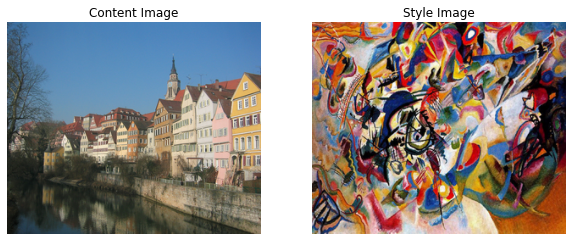

In [13]:
def load_image1(path):
    image = imageio.imread(path)
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    #image = image - MEAN_VALUES
    return image

plt.figure(figsize=(10,10))
style_image = load_image1(STYLE_IMAGE)
content_image = load_image1(CONTENT_IMAGE)
plt.subplot(1,2,2)
plt.imshow(style_image[0])
plt.title("Style Image")
plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(content_image[0])
plt.title("Content Image")
plt.axis('off')

In [7]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last 3 fully connected layers are not used.
    """
    
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][2][0][0]
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

In [8]:
import imageio

def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def load_image(path):
    """
    Returns image with correct shape and mean value subtracted
    """
    image = imageio.imread(path)
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image = image - MEAN_VALUES
    return image

def save_image(path, image):
    """
    Saves image with correct shape and mean value added back
    """
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    imageio.imsave(path, image)

In [9]:
def style_transfer(STYLE_LAYERS, filename, ALPHA = 100, BETA = 5, ITERATIONS = 2000, lr=2.0):

    model = load_vgg_model(VGG_MODEL)

    def content_loss_func(sess, model):
        """
        Content loss function as defined in the paper.
        """
        def _content_loss(p, x):
            # N is the number of filters (at layer l).
            N = p.shape[3]
            # M is the height times the width of the feature map (at layer l).
            M = p.shape[1] * p.shape[2]
            # eauation 1 of paper
            return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(x - p, 2))
        return _content_loss(sess.run(model['conv4_2']), model['conv4_2'])

    def style_loss_func(sess, model):
        """
        Style loss function as defined in the paper.
        """
        def _gram_matrix(F, N, M):
            """
            The gram matrix G.  equation 3 of paper
            """
            Ft = tf.reshape(F, (M, N))
            
            return tf.matmul(tf.transpose(Ft), Ft)

        def _style_loss(a, x):
            """
            The style loss calculation. equation 4 of the paper
            """
            # N is the number of filters (at layer l).
            N = a.shape[3]
            # M is the height times the width of the feature map (at layer l).
            M = a.shape[1] * a.shape[2]
            # A is the style representation of the original image (at layer l).
            A = _gram_matrix(a, N, M)
            # G is the style representation of the generated image (at layer l).
            G = _gram_matrix(x, N, M)
            # equation 4 of the paper
            result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
            return result

        E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
        W = [w for _, w in STYLE_LAYERS]
        # equation 5 of paper
        loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
        return loss

    
    sess=tf.InteractiveSession()
    #print('\n CONTENT IMAGE: ')
    content_image = load_image(CONTENT_IMAGE)
    #plt.imshow(content_image[0])
    #print('\n STYLE IMAGE: ')
    style_image = load_image(STYLE_IMAGE)
    #plt.imshow(style_image[0])


    # Generate an image with noise in content image
    input_image = generate_noise_image(content_image)
    # Generate white noise (this was not used, but one can comment the above and uncomment the below and experiment)
    #input_image = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

    sess.run(tf.initialize_all_variables())

    # Construct content_loss using content_image.
    sess.run(model['input'].assign(content_image))
    content_loss = content_loss_func(sess, model)

    # Construct style_loss using style_image.
    sess.run(model['input'].assign(style_image))
    style_loss = style_loss_func(sess, model)

    # Instantiate equation 7 of the paper.
    total_loss = ALPHA * content_loss + BETA * style_loss
    #total_loss = content_loss + style_loss
    # From the paper: jointly minimize the distance of a white noise image
    # from the content representation of the photograph in one layer of
    # the neywork and the style representation of the painting in a number
    # of layers of the CNN.
    #
    # The content is built from one layer, while the style is from five
    # layers. Then we minimize the total_loss, which is the equation 7.
    optimizer = tf.train.AdamOptimizer(lr)
    train_step = optimizer.minimize(total_loss)

    sess.run(tf.initialize_all_variables())
    sess.run(model['input'].assign(input_image))

    sess.run(tf.initialize_all_variables())
    sess.run(model['input'].assign(input_image))
    for it in range(ITERATIONS):
        sess.run(train_step)
        if it%500 == 0:
            # Print every 500 iteration.
            mixed_image = sess.run(model['input'])
            print('Iteration %d' % (it))
            sess.run(tf.reduce_sum(mixed_image))
            print('LOSS: ', sess.run(total_loss))

            if not os.path.exists(OUTPUT_DIR):
                os.mkdir(OUTPUT_DIR)

    save_image(filename, mixed_image)
    sess.close()
    del sess
    #plt.imshow(mixed_image[0])
    return None

In [2]:

def plot_grid():
    """
    Function to plot the grid
    """
    images = ['conv1_1_5.png','conv1_1_4.png','conv1_1_3.png','conv1_1_2.png',
            'conv2_1_5.png','conv2_1_4.png','conv2_1_3.png','conv2_1_2.png',
            'conv3_1_5.png','conv3_1_4.png','conv3_1_3.png','conv3_1_2.png',
            'conv4_1_5.png','conv4_1_4.png','conv4_1_3.png','conv4_1_2.png',
            'conv5_1_5.png','conv5_1_4.png','conv5_1_3.png','conv5_1_2.png',
          ]
    cols_ = ['alpha/beta {}'.format(col) for col in ['10-5','10-4','10-3','10-2']]
    rows_ = ['Conv {}'.format(row) for row in ['1_1', '2_1', '3_1', '4_1','5_1']]

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10,10))

    columns = 4
    rows = 5
    cnt = 1
    for image in images:
        img = plt.imread(image)
        fig.add_subplot(rows, columns, cnt)
        plt.imshow(img)
        plt.axis('off')
        cnt +=1
        for ax, col in zip(axes[0], cols_):
            ax.set_title(col)


        for ax, row in zip(axes[:,0], rows_):
            ax.set_ylabel(row, rotation=90, size='large')

        for ax in axes.flat:
            ax.set_xticks([])
            ax.set_yticks([])

      #fig.tight_layout()
        plt.axis('off')
        plt.show()

In [11]:
%time
# running the models built
content_layers = ['block4_conv2'] 
#('conv1_1', 1.0)],
# Weights of different convolutional layers have been used as mentioned in the paper
# The factor wl was always equal to one divided by the number of active layers with a non-zero loss-weight wl
style_layers_set = [[('conv1_1', 1)],    # # active layers=1
                    [('conv1_1', .5),('conv2_1', .5)], # # active layers=2
                    [('conv1_1', 1/3),('conv2_1', 1/3),('conv3_1', 1/3)], # # active layers=3
                    [('conv1_1', .25),('conv2_1', .25),('conv3_1', .25),('conv4_1', .25)],
                    [('conv1_1', .2),('conv2_1', .2),('conv3_1', .2),('conv4_1', .2),('conv5_1', .2)]]

# Here we try to set different learning rates for different outputs to mimic the figure 3 of the paper
learning_rate_set = [[10000 ,50,10,.1],
                     [100 ,50,10,1],
                     [100 ,50,10,2],
                     [100 ,2,1,.5],
                     [100 ,2,.5,.4]]
alpha = 1                 # content weight
beta_ = [1e5,1e4,1e3,1e2] # style weight
counter = 1
for style_layers,learning_rate in zip(style_layers_set,learning_rate_set):
    beta = 5
    for bt,lr_ in zip(beta_,learning_rate):
        #lr_ = 100
        im = style_layers[-1][0]
        
        image_name = im + "_" + str(beta) + ".png"
        #print(image_name)
        print(style_layers,image_name,bt,"learning_rate = ",lr_)
        #if im == "conv5_1" and beta == 2:
        style_transfer(STYLE_LAYERS = style_layers, filename=image_name, ALPHA = 1, BETA = bt, ITERATIONS = 2000, lr=lr_)  #10^-5 conv1_1
          #plot_grid()
        beta -=1
        
    counter += 1


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs
[('conv1_1', 1)] conv1_1_5.png 100000.0 learning_rate =  10000
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration 0
LOSS:  1.2363699e+20
Iteration 500
LOSS:  22704233000000.0
Iteration 1000
LOSS:  12723710000000.0
Iteration 1500
LOSS:  8216780000000.0
[('conv1_1', 1)] conv1_1_4.png 10000.0 learning_rate =  50
Iteration 0
LOSS:  6162087000.0
Iteration 500
LOSS:  37187.375
Iteration 1000
LOSS:  42094.812
Iteration 1500
LOSS:  49756.348
[('conv1_1', 1)] conv1_1_3.png 1000.0 learning_rate =  10
Iteration 0
LOSS:  386122780.0
Iteration 500
LOSS:  16168.847
Iteration 1000
LOSS:  11854.833
Iteration 1500
LOSS:  9692.218
[('conv1_1', 1)] conv1_1_2.png 100.0 learning_rate =  0.1
Iteration 0
LOSS:  48767756.0
Iteration 500
LOSS:  4735897.0
Iteration 1000
LOSS:  1520714.5
Iteration 1500
LOSS:  459834.7
[('con

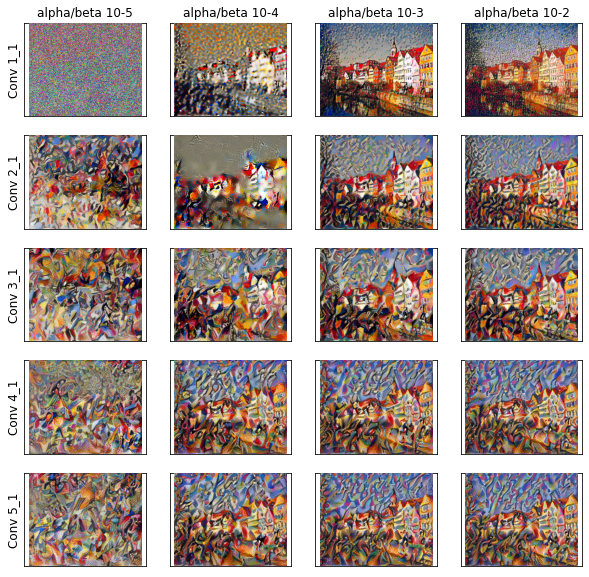

In [12]:
plot_grid()

The colours are different from the figure in the paper.This may be because of resolution difference between the image used by the authors and that used by us.